# scDALI discoveries using alternative cell-state representations

In [1]:
experiment_ids = 'f1'
timepoints = 'all'
regions = 'cusanovich_dm6_peaks_1kb'
correction = 'wasp'

In [2]:
label = '_'.join([experiment_ids, timepoints, 'windows'])
wasp_corrected = True if correction == 'wasp' else False

## Imports

In [3]:
# general
import sys
import os

In [4]:
# tools
import numpy as np
import pandas as pd
import scanpy as sc

from scdali import run_tests

sc.settings.verbosity = 3

In [5]:
# plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'

In [6]:
# local
sys.path.append('..')
from utils import settings

## Global variables

In [7]:
DALIHOM_PVAL = 'DALIHOM'
DALIHET_PVAL = 'DALIHET_VAE'
DALIHET_LINEAGE_PVAL = lambda x : 'DALIHET_TIME_%s' % x
DALIJOINT_PVAL = 'DALIJOINT'
DALIJOINT_RHO = 'DALIJOINT_RHO'

## Plot settings

In [8]:
SAVE_PLOTS = True

In [9]:
%config InlineBackend.figure_format = 'retina'

plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 7
sns.set_style("ticks")

In [10]:
PLOT_DIRECTORY = 'figures/cellstate_comparison'
if not os.path.exists(PLOT_DIRECTORY):
    os.makedirs(PLOT_DIRECTORY)

## Load processed anndata

In [11]:
adata_total = sc.read(os.path.join(settings.DATA_DIR, label, 'total_counts_vae_processed.h5ad'))

In [12]:
cistopic_emb = pd.read_csv(os.path.join(settings.DATA_DIR, 'cistopic', 'topic.embedding.50.txt'), sep='\t')
cistopic_emb.index = adata_total.obs_names
adata_total.obsm['X_lda'] = cistopic_emb

In [13]:
fname = '_'.join(['SS148', regions, correction, 'allelic_counts.h5ad'])
adata = sc.read(os.path.join(settings.DATA_DIR, label, fname))
adata.obsm = adata_total[adata.obs_names, :].obsm

In [14]:
adata

AnnData object with n_obs × n_vars = 10220 × 12861
    obs: 'timepoint', 'exp_id', 'time_vae', 'leiden_vae', 'lineage_muscle', 'lineage_nervous', 'annotation', 'n_peaks_by_counts', 'log1p_n_peaks_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_peaks', 'pct_counts_in_top_100_peaks', 'pct_counts_in_top_200_peaks', 'pct_counts_in_top_500_peaks'
    var: 'chr', 'start', 'end', 'length', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'count_variance', 'allelic_counts', 'mean_accessible', 'lineage_muscle_covered', 'lineage_nervous_covered', 'dalihet_vae', 'dalihet_leiden', 'dalihet_time', 'dalijoint', 'dalijoint_rho', 'lrt', 'dalihet_time_muscle', 'dalihet_time_nervous', 'BDGP_dist', 'BDGP_name', 'BDGP_terms', 'CAD_overlap', 'CAD_terms', 'DHS_peak', 'DN_peak', 'ELAV_peak', 'MEF_peak', 'TSS_1kb_peak', 'dalihet_time_muscle_bh', 'dalihet_time_nervous_bh', 'dalihet_vae_bh', 'dalihet_vae_ih

In [27]:
adata.obsm['X_pca'].shape

(10220, 19)

In [28]:
adata.obsm['X_lda'].shape

(10220, 50)

In [15]:
results_vae = run_tests(A=adata.X.A, D=adata.layers['allelic_total'].A, model='scDALI-Het', cell_state=adata.obsm['X_vae'] / adata.obsm['X_vae'].max(), n_cores=10)

[scdali] Processing 12861 regions on 10 core(s) ... 


100%|██████████| 10/10 [05:03<00:00, 30.31s/it]


In [16]:
results_pca = run_tests(A=adata.X.A, D=adata.layers['allelic_total'].A, model='scDALI-Het', cell_state=adata.obsm['X_pca'] / adata.obsm['X_pca'].max(), n_cores=10)

[scdali] Processing 12861 regions on 10 core(s) ... 


100%|██████████| 10/10 [04:10<00:00, 25.07s/it]


In [17]:
results_lda = run_tests(A=adata.X.A, D=adata.layers['allelic_total'].A, model='scDALI-Het', cell_state=adata.obsm['X_lda'] / adata.obsm['X_lda'].max(), n_cores=10)

[scdali] Processing 12861 regions on 10 core(s) ... 


100%|██████████| 10/10 [04:14<00:00, 25.48s/it]


[3.6 1.8]


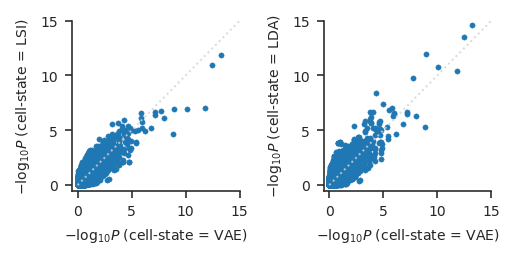

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(3.6, 1.8))

ax = axes[0]
sns.scatterplot(
    x=-np.log10(results_vae['pvalues']), 
    y=-np.log10(results_pca['pvalues']),
    edgecolor=None, 
    rasterized=True,
    s=7,
    ax=ax
)
ax.set(
    xlabel=r'$-\log_{10}P$ (cell-state = VAE)', 
    ylabel=r'$-\log_{10}P$ (cell-state = LSI)',
    xlim=[-.5, 15], ylim=[-.5, 15], 
    xticks=np.linspace(0, 15, 4),
    yticks=np.linspace(0, 15, 4))
ax_max = max(ax.get_ylim()[1], ax.get_xlim()[1])
ax.plot([0, ax_max], [0, ax_max], alpha=0.8, linestyle=':', c='lightgrey', linewidth=1)

ax = axes[1]
ax = sns.scatterplot(
    x=-np.log10(results_vae['pvalues']), 
    y=-np.log10(results_lda['pvalues']),
    edgecolor=None, 
    rasterized=True,
    s=7,
    ax=ax
)
ax.set(
    xlabel=r'$-\log_{10}P$ (cell-state = VAE)', 
    ylabel=r'$-\log_{10}P$ (cell-state = LDA)',
    xlim=[-.5, 15], ylim=[-.5, 15],
    xticks=np.linspace(0, 15, 4),
    yticks=np.linspace(0, 15, 4))
ax_max = max(ax.get_ylim()[1], ax.get_xlim()[1])
ax.plot([0, ax_max], [0, ax_max], alpha=0.8, linestyle=':', c='lightgrey', linewidth=1)

plt.tight_layout()
sns.despine()

print(fig.get_size_inches())
if SAVE_PLOTS:
    fig.savefig(PLOT_DIRECTORY + '/cellstate_comparison.svg', dpi=350)